# Applied Data Science Capstone Final Project
# -The Battle of Neighborhoods

## Introduction: Business Problem

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

!pip install geocoder
import geocoder
from geopy.geocoders import Nominatim
import geopy.distance
from pandas.io.json import json_normalize

import folium 

from sklearn.cluster import KMeans

### Webscraping and create dataframe

In [2]:
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(source, 'lxml')

table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [3]:
print('Number of rows of the dataframe:', df.shape[0])
print('Number of columns of the dataframe:', df.shape[1])

Number of rows of the dataframe: 103
Number of columns of the dataframe: 3


###  Get latitude and the longitude coordinates of each neighborhood
I am not able to get the geographical coordinates of the neighborhoods using the Geocoder package so I comment out the corresponding codes and use GeoSpatial Dataset instead.

In [4]:
# df['Latitude'] = 0
# df['Longitude'] = 0
# for i in range(len(df)):
#     postal_code = df.loc[i, 'PostalCode']
#     # initialize your variable to None
#     lat_lng_coords = None

#     # loop until you get the coordinates
#     while (lat_lng_coords is None):
#         g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
#         lat_lng_coords = g.latlng
#         print(i)

#     latitude = lat_lng_coords[0]
#     longitude = lat_lng_coords[1]
#     df.loc[i, 'Latitude'] = latitude
#     df.loc[i, 'Longitude'] = longitude

In [5]:
geo_cord = pd.read_csv('Geospatial_Coordinates.csv')
geo_cord = geo_cord.rename(columns={'Postal Code': 'PostalCode'})
geo_cord.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
df = pd.merge(df, geo_cord, how='inner', on='PostalCode')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [7]:
pop_data = pd.read_csv('population.CSV')
pop_data = pop_data[['Geographic code', 'Population, 2016']]
pop_data = pop_data.rename(columns={'Geographic code':'PostalCode', 'Population, 2016':'Population'})
pop_data.head()

,PostalCode,Population
0,A0A,46587
1,A0B,19792
2,A0C,12587
3,A0E,22294
4,A0G,35266


In [8]:
df = pd.merge(df, pop_data, how='inner', on='PostalCode')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Population
0,M3A,North York,Parkwoods,43.753259,-79.329656,34615
1,M4A,North York,Victoria Village,43.725882,-79.315572,14443
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,41078
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,21048
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,10


### Use geopy library to get the latitude and longitude values of Toronto

In [9]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Calculate distance (in meters) between each neighborhood to center of Toronto.

In [10]:
df['Distance from center'] = float(0)
for i in range(len(df)):
    neigh_latitude = df.loc[i, 'Latitude']
    neigh_longitude = df.loc[i, 'Longitude']
    neigh_cord = (neigh_latitude, neigh_longitude)
    toronto_cord = (latitude, longitude)
    df.loc[i, 'Distance from center'] = geopy.distance.vincenty(neigh_cord, toronto_cord).meters
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Population,Distance from center
0,M3A,North York,Parkwoods,43.753259,-79.329656,34615,11917.949753
1,M4A,North York,Victoria Village,43.725882,-79.315572,14443,9751.235551
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,41078,1881.525138
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,21048,9730.670477
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,10,1077.658778


### Create a map of Toronto with neighborhoods superimposed on top

In [11]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Utilize Foursquare API to explore the neighborhoods

In [12]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    CN_res_category = '4bf58dd8d48988d145941735' # 'Root' category for all Chinese Restaurant venues
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            CN_res_category,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return nearby_venues

In [14]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )
toronto_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,The Bean Sprout,43.742229,-79.313577,Chinese Restaurant
1,Parkwoods,43.753259,-79.329656,Omni Palace Noodle House,43.771047,-79.331570,Chinese Restaurant
2,Parkwoods,43.753259,-79.329656,Dragon Pearl Buffet 龍珠,43.753693,-79.349730,Chinese Restaurant
3,Parkwoods,43.753259,-79.329656,China Gourmet,43.755189,-79.348382,Chinese Restaurant
4,Parkwoods,43.753259,-79.329656,Spicy Chicken House,43.760639,-79.325671,Chinese Restaurant
...,...,...,...,...,...,...,...
2044,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Ancom Chinese Restaurant,43.624481,-79.509448,Chinese Restaurant
2045,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Mandarin Buffet,43.621352,-79.523015,Chinese Restaurant
2046,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Li's Oriental Kitchen,43.637787,-79.539134,Chinese Restaurant
2047,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Lemongrass,43.645010,-79.522379,Thai Restaurant


In [15]:
delete_lst = ['Bar', 'Bubble Tea Shop', 'Church', 'Grocery Store', 'Indonesian Restaurant', 
              'Japanese Restaurant', 'Korean Restaurant', 'Shopping Mall', 'Sushi Restaurant', 
              'Tea Room', 'Thai Restaurant', 'Bakery', 'Food Court', 'Supermarket']
delete_idx = []
for i in range(len(toronto_venues)):
    if toronto_venues.loc[i, 'Venue Category'] in delete_lst:
        delete_idx.append(i)

toronto_venues = toronto_venues.drop(delete_idx)

In [16]:
toronto_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,The Bean Sprout,43.742229,-79.313577,Chinese Restaurant
1,Parkwoods,43.753259,-79.329656,Omni Palace Noodle House,43.771047,-79.331570,Chinese Restaurant
2,Parkwoods,43.753259,-79.329656,Dragon Pearl Buffet 龍珠,43.753693,-79.349730,Chinese Restaurant
3,Parkwoods,43.753259,-79.329656,China Gourmet,43.755189,-79.348382,Chinese Restaurant
4,Parkwoods,43.753259,-79.329656,Spicy Chicken House,43.760639,-79.325671,Chinese Restaurant
...,...,...,...,...,...,...,...
2042,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,Ancom Chinese Restaurant,43.624481,-79.509448,Chinese Restaurant
2044,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Ancom Chinese Restaurant,43.624481,-79.509448,Chinese Restaurant
2045,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Mandarin Buffet,43.621352,-79.523015,Chinese Restaurant
2046,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Li's Oriental Kitchen,43.637787,-79.539134,Chinese Restaurant


Record the number of Chinese Restaurant for each neighborhood.

In [17]:
df['Number of CN Restaurant'] = 0
df_temp = toronto_venues.groupby('Neighborhood').count()
for i in range(len(df)):
    neigh = df.loc[i, 'Neighborhood']
    if neigh in df_temp.index.tolist():
        df.loc[i, 'Number of CN Restaurant'] = df_temp.loc[neigh, 'Venue']
df

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Population,Distance from center,Number of CN Restaurant
0,M3A,North York,Parkwoods,43.753259,-79.329656,34615,11917.949753,7
1,M4A,North York,Victoria Village,43.725882,-79.315572,14443,9751.235551,5
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,41078,1881.525138,39
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,21048,9730.670477,5
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,10,1077.658778,98
...,...,...,...,...,...,...,...,...
97,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,10787,9923.318339,5
98,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,30472,1376.706656,95
99,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558,10,5135.793455,3
100,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,21299,9440.207261,3


Let's check how many venues were returned for each neighborhood.

Let's find out how many unique categories can be curated from all the returned venues.

In [18]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 20 uniques categories.


### Analyze Each Neighborhood

In [19]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Asian Restaurant,BBQ Joint,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dongbei Restaurant,Dumpling Restaurant,Fried Chicken Joint,Hakka Restaurant,Hong Kong Restaurant,Hotpot Restaurant,Indian Chinese Restaurant,Noodle House,Peking Duck Restaurant,Ramen Restaurant,Seafood Restaurant,Shanghai Restaurant,Szechuan Restaurant,Taiwanese Restaurant
0,Parkwoods,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Parkwoods,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
# examine the new dataframe size
toronto_onehot.shape

(1960, 21)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [21]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Asian Restaurant,BBQ Joint,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dongbei Restaurant,Dumpling Restaurant,Fried Chicken Joint,Hakka Restaurant,Hong Kong Restaurant,Hotpot Restaurant,Indian Chinese Restaurant,Noodle House,Peking Duck Restaurant,Ramen Restaurant,Seafood Restaurant,Shanghai Restaurant,Szechuan Restaurant,Taiwanese Restaurant
0,Agincourt,0.025641,0.0,0.102564,0.692308,0.0,0.051282,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.025641,0.0,0.0,0.025641,0.000,0.000
1,"Alderwood, Long Branch",0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000,0.000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.500000,0.0,0.000000,0.500000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000,0.000
3,Bayview Village,0.000000,0.0,0.000000,0.750000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.125,0.125
4,"Bedford Park, Lawrence Manor East",0.200000,0.0,0.000000,0.800000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000,0.000


In [22]:
# examine the new dataframe size
toronto_grouped.shape

(98, 21)

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Cantonese Restaurant,Hong Kong Restaurant,Dim Sum Restaurant,Asian Restaurant,Shanghai Restaurant,Peking Duck Restaurant,Dumpling Restaurant,BBQ Joint,Comfort Food Restaurant
1,"Alderwood, Long Branch",Chinese Restaurant,Taiwanese Restaurant,Szechuan Restaurant,BBQ Joint,Cantonese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dongbei Restaurant,Dumpling Restaurant,Fried Chicken Joint
2,"Bathurst Manor, Wilson Heights, Downsview North",Asian Restaurant,Chinese Restaurant,Szechuan Restaurant,BBQ Joint,Cantonese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dongbei Restaurant,Dumpling Restaurant,Fried Chicken Joint
3,Bayview Village,Chinese Restaurant,Taiwanese Restaurant,Szechuan Restaurant,BBQ Joint,Cantonese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dongbei Restaurant,Dumpling Restaurant,Fried Chicken Joint
4,"Bedford Park, Lawrence Manor East",Chinese Restaurant,Asian Restaurant,Szechuan Restaurant,BBQ Joint,Cantonese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dongbei Restaurant,Dumpling Restaurant,Fried Chicken Joint


In [25]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Cantonese Restaurant,Hong Kong Restaurant,Dim Sum Restaurant,Asian Restaurant,Shanghai Restaurant,Peking Duck Restaurant,Dumpling Restaurant,BBQ Joint,Comfort Food Restaurant
1,"Alderwood, Long Branch",Chinese Restaurant,Taiwanese Restaurant,Szechuan Restaurant,BBQ Joint,Cantonese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dongbei Restaurant,Dumpling Restaurant,Fried Chicken Joint
2,"Bathurst Manor, Wilson Heights, Downsview North",Asian Restaurant,Chinese Restaurant,Szechuan Restaurant,BBQ Joint,Cantonese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dongbei Restaurant,Dumpling Restaurant,Fried Chicken Joint
3,Bayview Village,Chinese Restaurant,Taiwanese Restaurant,Szechuan Restaurant,BBQ Joint,Cantonese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dongbei Restaurant,Dumpling Restaurant,Fried Chicken Joint
4,"Bedford Park, Lawrence Manor East",Chinese Restaurant,Asian Restaurant,Szechuan Restaurant,BBQ Joint,Cantonese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dongbei Restaurant,Dumpling Restaurant,Fried Chicken Joint
...,...,...,...,...,...,...,...,...,...,...,...
93,"Willowdale, Newtonbrook",Chinese Restaurant,Cantonese Restaurant,Dim Sum Restaurant,Taiwanese Restaurant,Szechuan Restaurant,BBQ Joint,Comfort Food Restaurant,Dongbei Restaurant,Dumpling Restaurant,Fried Chicken Joint
94,Woburn,Chinese Restaurant,Hakka Restaurant,Szechuan Restaurant,BBQ Joint,Cantonese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dongbei Restaurant,Dumpling Restaurant,Fried Chicken Joint
95,Woodbine Heights,Chinese Restaurant,Taiwanese Restaurant,Szechuan Restaurant,BBQ Joint,Cantonese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dongbei Restaurant,Dumpling Restaurant,Fried Chicken Joint
96,York Mills West,Chinese Restaurant,Taiwanese Restaurant,Szechuan Restaurant,BBQ Joint,Cantonese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dongbei Restaurant,Dumpling Restaurant,Fried Chicken Joint


### Cluster Neighborhoods
Run k-means to cluster the neighborhood into 5 clusters.

First, we can see that some neighborhoods do not have Chinese restaurant in 2km radius. These neighborhoods may also be potential locations for our stakeholders.

In [26]:
for neighborhood in df['Neighborhood'].unique().tolist():
    if neighborhood not in neighborhoods_venues_sorted['Neighborhood'].unique().tolist():
        print(neighborhood)

Islington Avenue
Rouge Hill, Port Union, Highland Creek
Humberlea, Emery
Upper Rouge


Now we can merge our previous dataframes into one final dataframe for the kmeans clustering algorithm.

In [27]:
df_basic = df[['Neighborhood', 'Population', 'Number of CN Restaurant']]
df_basic

,Neighborhood,Population,Number of CN Restaurant
0,Parkwoods,34615,7
1,Victoria Village,14443,5
2,"Regent Park, Harbourfront",41078,39
3,"Lawrence Manor, Lawrence Heights",21048,5
4,Ontario Provincial Government,10,98
...,...,...,...
97,"The Kingsway, Montgomery Road, Old Mill North",10787,5
98,Church and Wellesley,30472,95
99,Enclave of M4L,10,3
100,"Old Mill South, King's Mill Park, Sunnylea, Hu...",21299,3


In [28]:
df_final = pd.merge(df_basic, toronto_grouped, how='inner', on='Neighborhood')
df_final

,Neighborhood,Population,Number of CN Restaurant,Asian Restaurant,BBQ Joint,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dongbei Restaurant,Dumpling Restaurant,Fried Chicken Joint,Hakka Restaurant,Hong Kong Restaurant,Hotpot Restaurant,Indian Chinese Restaurant,Noodle House,Peking Duck Restaurant,Ramen Restaurant,Seafood Restaurant,Shanghai Restaurant,Szechuan Restaurant,Taiwanese Restaurant
0,Parkwoods,34615,7,0.000000,0.0,0.000000,0.857143,0.000000,0.000000,0.0,0.000000,0.000000,0.142857,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
1,Victoria Village,14443,5,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,"Regent Park, Harbourfront",41078,39,0.000000,0.0,0.000000,0.948718,0.000000,0.000000,0.0,0.000000,0.025641,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.025641
3,"Lawrence Manor, Lawrence Heights",21048,5,0.200000,0.0,0.000000,0.800000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
4,Ontario Provincial Government,10,98,0.030612,0.0,0.000000,0.887755,0.000000,0.030612,0.0,0.020408,0.000000,0.000000,0.0,0.010204,0.000000,0.010204,0.0,0.010204,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,"The Kingsway, Montgomery Road, Old Mill North",10787,5,0.000000,0.0,0.000000,0.800000,0.000000,0.200000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
94,Church and Wellesley,30472,95,0.021053,0.0,0.010526,0.863158,0.010526,0.021053,0.0,0.021053,0.000000,0.000000,0.0,0.010526,0.000000,0.010526,0.0,0.010526,0.0,0.0,0.010526,0.010526
95,Enclave of M4L,10,3,0.000000,0.0,0.000000,0.666667,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.333333,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
96,"Old Mill South, King's Mill Park, Sunnylea, Hu...",21299,3,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000


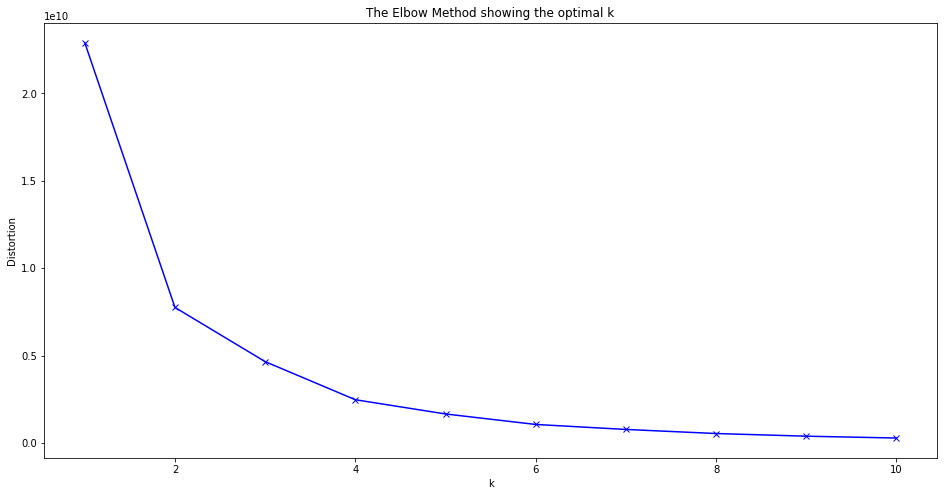

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline 
distortions = []
K = range(1,11)
elbow_df = df_final.drop('Neighborhood', 1)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(elbow_df)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [30]:
# from yellowbrick.cluster import KElbowVisualizer

# df_final = df_final.drop('Neighborhood', 1)
# # Instantiate the clustering model and visualizer
# model = KMeans()
# visualizer = KElbowVisualizer(model, k=(3,11))

# visualizer.fit(df_final)
# visualizer

In [31]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = df_final.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 3, 1, 3, 0, 2, 0, 3, 0, 3], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [32]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df[['Neighborhood', 'Latitude', 'Longitude', 'Population', 'Number of CN Restaurant']]

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.merge(neighborhoods_venues_sorted.set_index('Neighborhood'), how='inner', on='Neighborhood')

toronto_merged.head()

,Neighborhood,Latitude,Longitude,Population,Number of CN Restaurant,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,43.753259,-79.329656,34615,7,3,Chinese Restaurant,Hakka Restaurant,Szechuan Restaurant,BBQ Joint,Cantonese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dongbei Restaurant,Dumpling Restaurant,Fried Chicken Joint
1,Victoria Village,43.725882,-79.315572,14443,5,2,Chinese Restaurant,Taiwanese Restaurant,Szechuan Restaurant,BBQ Joint,Cantonese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dongbei Restaurant,Dumpling Restaurant,Fried Chicken Joint
2,"Regent Park, Harbourfront",43.654260,-79.360636,41078,39,3,Chinese Restaurant,Taiwanese Restaurant,Fried Chicken Joint,Szechuan Restaurant,BBQ Joint,Cantonese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dongbei Restaurant,Dumpling Restaurant
3,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,21048,5,0,Chinese Restaurant,Asian Restaurant,Szechuan Restaurant,BBQ Joint,Cantonese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dongbei Restaurant,Dumpling Restaurant,Fried Chicken Joint
4,Ontario Provincial Government,43.662301,-79.389494,10,98,3,Chinese Restaurant,Asian Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Ramen Restaurant,Noodle House,Hotpot Restaurant,BBQ Joint,Cantonese Restaurant,Comfort Food Restaurant


Finally, let's visualize the resulting clusters.

In [33]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

Cluster 0

In [34]:
print('Number of neighborhoods in Cluster 0:', len(toronto_merged[toronto_merged['Cluster Labels'] == 0]))
print('Mean population:', toronto_merged[toronto_merged['Cluster Labels'] == 0]['Population'].mean())
print('Mean restaurant:', toronto_merged[toronto_merged['Cluster Labels'] == 0]['Number of CN Restaurant'].mean())

Number of neighborhoods in Cluster 0: 19
Mean population: 32343.36842105263
Mean restaurant: 14.473684210526315


Cluster 1

In [35]:
print('Number of neighborhoods in Cluster 1:', len(toronto_merged[toronto_merged['Cluster Labels'] == 1]))
print('Mean population:', toronto_merged[toronto_merged['Cluster Labels'] == 1]['Population'].mean())
print('Mean restaurant:', toronto_merged[toronto_merged['Cluster Labels'] == 1]['Number of CN Restaurant'].mean())

Number of neighborhoods in Cluster 1: 31
Mean population: 21400.74193548387
Mean restaurant: 31.032258064516128


Cluster 2

In [36]:
print('Number of neighborhoods in Cluster 2:', len(toronto_merged[toronto_merged['Cluster Labels'] == 2]))
print('Mean population:', toronto_merged[toronto_merged['Cluster Labels'] == 2]['Population'].mean())
print('Mean restaurant:', toronto_merged[toronto_merged['Cluster Labels'] == 2]['Number of CN Restaurant'].mean())

Number of neighborhoods in Cluster 2: 11
Mean population: 24531.636363636364
Mean restaurant: 17.363636363636363


Cluster 3

In [37]:
print('Number of neighborhoods in Cluster 3:', len(toronto_merged[toronto_merged['Cluster Labels'] == 3]))
print('Mean population:', toronto_merged[toronto_merged['Cluster Labels'] == 3]['Population'].mean())
print('Mean restaurant:', toronto_merged[toronto_merged['Cluster Labels'] == 3]['Number of CN Restaurant'].mean())

Number of neighborhoods in Cluster 3: 37
Mean population: 29074.702702702703
Mean restaurant: 14.378378378378379


# Thank you for reviewing my assignment!